# LDA Topic Model 

This code is pulled from:
* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
* https://highdemandskills.com/topic-modeling-lda/

## Import Libraries

In [1]:
import pandas as pd

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/connorgilmore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import models

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/connorgilmore/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
extended_stop_words = ['guys', 'syndicated', 'mentoring', 'syndicate', 'club', 'mentor', 'thing', 'people', 'really',
                      'syndication', 'call', 'person', 'stuff']
stop_words.extend(extended_stop_words)

## Import Data

In [5]:
transcripts_df = pd.read_csv('documents_w_clusters.csv')

In [6]:
transcripts_df.head()

,Unnamed: 0,Unnamed: 0.1,file_name,contents,cleaned,lemmatized,no_of_words,cluster,x0,x1
0,0,0,[UPDATED] PC - February 2021 - Mastermind with...,"other hand if he says, You give me 5% of every...",hand says give everything dont get credit basi...,hand say not credit basic bread s different st...,3475,1,0.406383,-0.028027
1,1,1,"April 8, 2021 - Ask the Mentors Q_A Call on De...","JO\n\noften, it's 100%, smokescreen, nobody li...",jo often smokescreen nobody likes idea commitm...,jo smokescreen like idea commitment general wa...,4444,0,-0.050892,0.176329
2,2,2,"April 14, 2021 - Ask the Mentors Q_A Call on C...","JO\n\nJO\n\nbelieve in that, and then develop ...",jo jo believe develop investing thesis based s...,jo jo believe develop invest thesis base scena...,4931,2,-0.150166,-0.132726
3,3,3,April 2021 - Ask the Mentors Q_A Call on Busin...,JO\n\nyour investor questionnaire. So you can ...,jo investor questionnaire one one sales call a...,jo investor questionnaire sale actually raise ...,4229,2,-0.251402,-0.079161
4,4,4,April 2021 - Ask the Mentors Q_A Call on Sales...,©) Craig Kamman_ 30:35\n\nJO\n\nyes. Okay. So ...,© craig kamman jo yes okay youre dealing party...,© craig kamman jo yes okay deal party know mea...,4475,2,-0.207295,-0.133082


In [13]:
mask = (transcripts_df['cluster'] == 2)
transcripts_df = pd.DataFrame(transcripts_df[mask])

In [14]:
len(transcripts_df)

38

## Data Prep

In [15]:
data = transcripts_df['contents']
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def remove_extra_stopwords(texts):
    new_outer_list = []
    for l in texts:
        inner_list = []
        for word in l:
            if (word not in extended_stop_words):
                inner_list.append(word)
        new_outer_list.append(inner_list)
    return new_outer_list 

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
data_words_nostops = remove_extra_stopwords(data_words_nostops)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])

## LDA

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [20]:
TFIDF = models.TfidfModel(corpus) # Fit TF-IDF model
trans_TFIDF = TFIDF[corpus]

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    i = start 
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print('Model ', i , ' Completed')
        i += 1

    return model_list, coherence_values

In [22]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=trans_TFIDF, texts=data_lemmatized, 
                                                        start=5, limit=20, step=1)

Model  5  Completed
Model  6  Completed
Model  7  Completed
Model  8  Completed
Model  9  Completed
Model  10  Completed
Model  11  Completed
Model  12  Completed
Model  13  Completed
Model  14  Completed
Model  15  Completed
Model  16  Completed
Model  17  Completed
Model  18  Completed
Model  19  Completed


## Visualize Performance Metrics

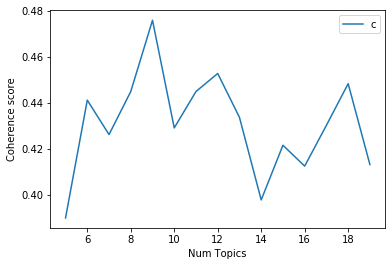

In [23]:
limit=20; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3901
Num Topics = 6  has Coherence Value of 0.4413
Num Topics = 7  has Coherence Value of 0.4263
Num Topics = 8  has Coherence Value of 0.445
Num Topics = 9  has Coherence Value of 0.476
Num Topics = 10  has Coherence Value of 0.4292
Num Topics = 11  has Coherence Value of 0.445
Num Topics = 12  has Coherence Value of 0.4529
Num Topics = 13  has Coherence Value of 0.4338
Num Topics = 14  has Coherence Value of 0.3979
Num Topics = 15  has Coherence Value of 0.4217
Num Topics = 16  has Coherence Value of 0.4126
Num Topics = 17  has Coherence Value of 0.4304
Num Topics = 18  has Coherence Value of 0.4484
Num Topics = 19  has Coherence Value of 0.4133


Optimal Model

In [25]:
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

[(0,
  '0.001*"ingo" + 0.001*"bio" + 0.001*"bond" + 0.001*"motive" + 0.001*"datum" '
  '+ 0.001*"sandwich" + 0.001*"pizza" + 0.001*"pandemic" + 0.001*"demand" + '
  '0.001*"client" + 0.001*"home_price" + 0.001*"slot" + 0.001*"influencer" + '
  '0.001*"page" + 0.001*"rent" + 0.001*"scratch" + 0.001*"introduction" + '
  '0.001*"database" + 0.001*"impression" + 0.001*"task" + 0.001*"chart" + '
  '0.001*"con" + 0.001*"application" + 0.001*"webinar" + 0.001*"housing" + '
  '0.001*"resident" + 0.001*"two" + 0.001*"commitment" + 0.001*"salesforce" + '
  '0.001*"market"'),
 (1,
  '0.001*"biggest_mistake" + 0.001*"operation" + 0.001*"influencer" + '
  '0.001*"tax" + 0.000*"brad_niebuhr" + 0.000*"officer" + 0.000*"breathing" + '
  '0.000*"breath" + 0.000*"ot" + 0.000*"objection" + 0.000*"congregation" + '
  '0.000*"software" + 0.000*"automation" + 0.000*"cpa" + 0.000*"budget" + '
  '0.000*"investor_portal" + 0.000*"structure" + 0.000*"solution" + '
  '0.000*"bowl" + 0.000*"cd" + 0.000*"stress" +

### Topics Per Document

In [27]:
def format_topics_sentences(ldamodel=optimal_model, corpus=trans_TFIDF, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=trans_TFIDF, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.9453,"bond, thesis, supply, inflation, bitcoin, gold...","[thesis, scenario, scenario, fall, dollar, inv..."
1,1,5.0,0.9461,"bond, thesis, supply, inflation, bitcoin, gold...","[sale, capital, marketing, side, sale, side, m..."
2,2,0.0,0.9425,"ingo, bio, bond, motive, datum, sandwich, pizz...","[party, mean, engineer, brother, architect, he..."
3,3,0.0,0.9202,"ingo, bio, bond, motive, datum, sandwich, pizz...","[way, market, home, price, bubble, mean, price..."
4,4,8.0,0.9491,"wage, inflation, blind_fund, cryptocurrency, o...","[question, decision, fit, team, objective, met..."
5,5,6.0,0.6315,"bus, revenue, phase, land, pre_existing, opera...","[component, deal, know, acquisition, expense, ..."
6,6,6.0,0.9495,"bus, revenue, phase, land, pre_existing, opera...","[part, vision, vision, stacey, vision, questio..."
7,7,8.0,0.9540,"wage, inflation, blind_fund, cryptocurrency, o...","[question, question, time, student, mass, mass..."
8,8,2.0,0.9487,"bio, bond, impression, blueprint, task, webina...","[product, service, pool, marketing, dollar, au..."
9,9,3.0,0.9504,"bond, shotgun, yield, youtube, return, heartst...","[target, world, positioning, content, identify..."


In [29]:
df_dominant_topic.to_csv('topics_per_doc_cluster_2.csv')